<i><b>Public AI</b></i>
<br>
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 1. DNN Basis**
# Appendix 2. Optimizer

### _Objective_
1. **Optimization**: 최적화가 무엇인지에 대해 알아보고 다양한 종류의 최적화에 대해 알아봅니다.

In [12]:
# 필요한 library import 및 tensorflow 버전 확인
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

np.random.seed(30)
tf.random.set_seed(30)

2.0.0


* 최적화 함수(Optimizer)를 평가하기 위해, 보통 Beale Function과 같은 test function을 많이 이용합니다.<br>

$$
f(x,y) = (1.5 - x + xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2
$$

In [13]:
# optimizer 평가를 위한 Beale test function
def beale(x, y):
    return ((1.5 - x + x * y) ** 2 + 
            (2.25 - x + x * y ** 2) ** 2 + 
            (2.625 - x + x * y ** 3) ** 2)

# Beale function 시각화 함수
def generate_beale_plot():
    xmin, xmax, xstep = -4.5, 4.5, .2
    ymin, ymax, ystep = -4.5, 4.5, .2

    xs_ = np.arange(xmin, xmax, xstep)
    ys_ = np.arange(ymin, ymax, ystep)

    x, y = np.meshgrid(xs_, ys_)
    z = beale(x, y)

    minima = np.array([3., .5])
    minima_ = minima.reshape(-1, 1)
    z_minima = beale(*minima)
    # z_minima = minima.reshape(-1, 1)

    plt.figure(figsize=(8, 5))
    ax = plt.axes(projection='3d', elev=50, azim=-50)

    ax.plot(*minima_, z_minima, 'r*', markersize=10)
    ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1,
                    edgecolor='None', alpha=0.3, cmap=plt.cm.jet)

    ax.view_init(30, 10)
    ax.set_title("Beale Function Visualization")
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    return ax

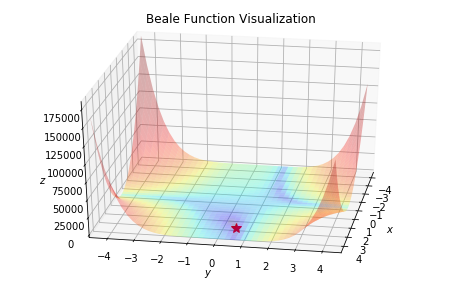

In [15]:
ax = generate_beale_plot()
ax

# \[ 1. Optimzation \]

신경망 학습의 목적은 Loss Function을 최소화하는 매개변수를 찾는 것입니다. 즉 매개변수의 최적값을 찾는 것이 주된 문제이며 이러한 문제를 푸는 것을 최적화라고 합니다.

## 1. Stochastic Gradient Descent

우리는 지금까지 매개변수의 최적값을 찾기 위해 매개변수의 기울기$(\frac { dL }{ dW } )$를 이용했습니다. <br>
매개변수의 기울기를 구하고 기울어진 방향, 즉 gradient의 반대 방향으로 매개변수의 값을 갱신하는 과정을 반복하여 점점 최적의 값에 다가갔습니다. <br><br>

이러한 과정에서 전체 train set을 사용하는 것을 **Batch Gradient Descent**라고 합니다. <br>
그러나 전체 train set을 사용하여 계산을 하는 경우 한번 step마다 전체 데이터에 대한 loss function을 계산해야 되므로 계산량이 매우 많아지는 단점이 있습니다.<br>
이를 방지하기 위해 보통은 **Stochastic Gradient Descent(SGD)**라는 방법을 사용합니다. <br>
SGD에서는 loss function을 계산할 때 전체데이터 대신 일부 작은 데이터의 모음(mini-batch)에 대해서만 loss function을 계산합니다. <br>
이 방법은 BGD보다 다소 부정확할 수 있지만, 계산속도가 훨씬 빠르며 여러번 반복할 경우 BGD의 걀과와 유사한 결과로 수렴합니다.

$${ W }_{ new }~ =~ { W }_{ old }~ -~ \alpha\ast \frac { \delta loss }{ \delta W } $$

SGD는 계산속도가 빠르고 구현도 쉽다는 장점이 있지만, 문제에 따라서는 비효율적인 경우도 있습니다. <br>
$f\left( x \right) =\frac { 1 }{ 20 } { x }^{ 2 }+{ y }^{ 2 }$ 와 같이 기울기 간 차이가 큰 경우 문제가 발생합니다. 이 식의 기울기를 그려보면 아래와 같습니다.

<img src="https://i.imgur.com/kfeTJZn.png" width="400" height="300"/><br>

위 식에서의 기울기는 y축 방향으로는 크고 x축 방향으로는 작습니다. 즉 y축 방향은 가파른데 x축 방향은 완만한 것입니다. <br>
위 그림을 보면 식이 최솟값이 되는 장소는 (0, 0)이지만 기울기 그림의 기울기 대부분은 (0, 0)을 가리키지 않는다는 점입니다. <br>
초깃값을 (-7.0, 2.0) 으로하고 식에 SGD를 적용해 보겠습니다.

<img src="https://i.imgur.com/hVZYt29.png" width="500" height="375"/><br>

SGD를 적용했을 떄 최적화 갱신 경로를 보면 매우 비효율적으로 움직이고 있음을 확인할 수 있습니다. 이것이 SGD의 단점입니다. <br>
방향에 따라 기울기가 달라지는 함수에서는 탐색경로가 비효율적이게 된다는 것입니다. <br>
이럴 때는 기울어진 방향으로만 진행되는 단순한 방식보다 더 효율적인 방식이 필요합니다.

### Tensorflow를 이용해 Stochastic Gradient Descent optimizer 시각화 하기

Stochastic Gradient Descent 최적화함수를 평가하기 위해 Beale Function을 이용해 시각화해보겠습니다. Tensorflow Keras에서는 `keras.optimizers.SGD(lr=learning_rate)`를 통해 stochastic gradient descent optimizer를 사용할 수 있습니다.

Beale Function의 시작점을 $(start\_x, start\_y, beale(start\_x, start\_y))$라고 할 때, <br>
optimizer를 이용해 갱신된 x, y, z 좌표를 추적하여 각각 xs, ys, zs라는 list에 담겠습니다.

In [5]:
start_x, start_y = -2., -4.

gd_xs = [start_x]
gd_ys = [start_y]
gd_zs = [beale(start_x, start_y)]

Tensorflow에서는 변수를 만들어 저장할 때, Python에서와는 달리 `tf.Variable`을 사용해 변수를 저장합니다.

In [6]:
x = tf.Variable(initial_value=start_x)
y = tf.Variable(initial_value=start_y)

Tensorflow에서는 자동 미분(주어진 입력 변수에 대한 연산의 그래디언트(gradient)를 계산하는 것)을 위한 `tf.GradientTape` API를 제공합니다.<br>
`with tf.GradientTape() as tape:` 구문안에서 계산을 하면 tape에 계산 과정을 기록해두었다가 `tape.gradient`를 이용해서 미분을 자동으로 구할 수 있습니다.

In [11]:
x = tf.Variable(initial_value=x.numpy())
y = tf.Variable(initial_value=y.numpy())

# optimizer 설정
optimizer = keras.optimizers.SGD(lr=0.00005)

for step in tqdm(range(10000)):
    # 자동 미분을 위한 tf.GradientTape() API
    with tf.GradientTape() as tape:
        # 10000번 갱신을 위한 max_iter 설정
        z = beale(x, y)
        
    # grads에 미분의 결과 저장    
    grads = tape.gradient(z, [x, y])
                
    # optimizer를 적용해 x, y, z값 갱신
    optimizer.apply_gradients(zip(grads, [x, y]))
    
    # 갱신된 x, y, z 값을 xs, ys, zs에 저장
    gd_xs.append(x.numpy())
    gd_ys.append(y.numpy())
    gd_zs.append(z.numpy())

100%|██████████| 10000/10000 [01:32<00:00, 107.89it/s]


gradient descent를 통해 갱신된 좌표들을 beale function에 나타내면 다음과 같습니다.

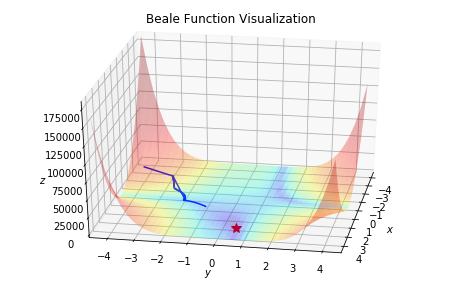

In [10]:
ax = generate_beale_plot()
ax.plot(gd_xs, gd_ys, gd_zs, 
        label='Gradient Descent', 
        color='b')
plt.show()

## 2. Momentum

**Momentum**은 말 그대로 Gradient Descent를 통해 이동하는 과정에 일종의 관성을 주는 방식입니다. <br>
현재 Gradient를 통해 이동하는 것과는 별개로 이전까지 이동했던 방식을 기억하면서 그 방향으로 일정 정도를 추가적으로 이동하는 것입니다. <br>
Momentum방식의 수식은 다음과 같습니다.

$${ V }_{ t+1 }~=~ \beta { V }_{ t } +\frac { \delta L }{ \delta W }$$
$${ W }_{ t+1 }~=~ { W }_{ t } - \alpha { V }_{ t+1 }$$

위 식을 살펴보면 이전까지의 이동을 담고 있는 항 ${ V }_{ t }$를 기억하고, 새로운 이동항을 구할 경우 이전까지의 이동에 momentum term을 곱해준 후 Gradient를 이용한 이동 step항을 더해준다는 것을 알 수 있습니다. <br><br>

SGD를 사용했을 때 비효율적이었던 $f\left( x \right)$에 momentum을 적용해보겠습니다.

<img src="https://i.imgur.com/bvfuzlM.png" width="500" height="375"/><br>

그림을 보면 모멘텀의 갱신 경로는 공이 그릇의 바닥을 구르는 듯한 움직임을 보입니다. <br>
SGD와 비교하면 지그재그 정도가 덜합니다. 이는 x축의 힘은 아주 작지만 방향은 변하지 않아서 한 방향으로 일정하게 가속하기 때문입니다. <br>
거꾸로 y축의 힘은 크지만 위 아래로 번갈아 받아서 상충하여 y 방향의 속도는 안정적이지 않습니다. <br>
전체적으로는 SGD보다 x축방향으로 빠르게 다가가 지그재그 움직임이 줄어드는 것을 확인할 수 있습니다.

### Tensorflow를 이용해 Momentum 시각화 하기

Momentum 최적화함수를 평가하기 위해 Beale Function을 이용해 시각화해보겠습니다.  Tensorflow Keras에서는 위에서 사용한 `keras.optimizers.SGD(lr=learning_rate)`의 momentum 인자를 사용해 momentum optimizer를 사용할 수 있습니다.

In [ ]:
def momentum(start_x, start_y, func, lr, max_iter, momentum):
    xs = [start_x]
    ys = [start_y]
    zs = [func(start_x, start_y)]
    x = tf.Variable(initial_value=start_x)
    y = tf.Variable(initial_value=start_y)
    for step in range(max_iter):
        with tf.GradientTape() as tape:
            x = tf.Variable(initial_value=x.numpy())
            y = tf.Variable(initial_value=y.numpy())
            z = func(x, y)
        grads = tape.gradient(z, [x, y])

        optimizer = keras.optimizers.SGD(lr=lr, momentum=momentum)
        optimizer.apply_gradients(zip(grads, [x, y]))
        
        xs.append(x.numpy())
        ys.append(y.numpy())
        zs.append(z.numpy())
    return xs, ys, zs

In [ ]:
start_x, start_y = -2.5, -4.

momentum_rate = 0.9
learning_rate = 0.00005 * (1-momentum_rate)
max_iter = 10000

momentum_xs, momentum_ys, momentum_zs = momentum(start_x, start_y, beale, learning_rate, max_iter, momentum_rate)

In [ ]:
ax = generate_beale_plot()
ax.plot(momentum_xs, momentum_ys, momentum_zs, 
        label='Momentum', 
        color='b')
plt.show()

## 3. Nesterov Accelerated Gradient(NAG)

**Nesterov Accelerated Gradient(NAG)**는 기존 Momentum 방식을 수정한 알고리즘 입니다. <br>
차이는 어느 시점의 기울기를 이용할 것인가에 있습니다. 빠른 이해를 돔기 위해 아래그림을 먼저 살펴보겠습니다.

<img src="https://i.imgur.com/49and6h.jpg" width="800" height="600"/><br>

Momentum 방식에서는 이동 벡터 ${V}_{t}$ 를 계산할 때 현재 위치에서의 gradient와 momentum step을 독립적으로 계산하고 합쳐줍니다. <br>
반면, NAG에서는 momentum step을 먼저 고려하여, momentum step을 먼저 이동했다고 생각한 후 그 자리에서의 gradient를 구해서 gradient step을 이동합니다. <br>
이를 수식으로 나타내면 다음과 같습니다.

$${ V }_{ t+1 }~=~ \beta{ v }_{ t } + { \nabla }_{ W }J(W-\beta{ v }_{ t } )$$
$${ W }_{ t+1 }~=~ {W}_{t} - \alpha{V}_{t+1}$$

NAG를 이용할 경우 Momentum 방식에 비해 보다 효과적으로 이동할 수 있습니다. <br>
Momentum 방식의 경우 멈춰야 할 시점에서도 관성에 의해 훨씬 멀리 갈수도 있다는 단점이 존재하는 반면에, NAG 방식의 경우 일단 모멘텀으로 이동을 어느정도 한 후 어떤 방식으로 이동해야할 지를 결정합니다. <br>
따라서 Momentum 방식의 빠른 이동에 대한 이점은 누리면서도, 멈춰야 할 적절한 시점에서 제동을 거는 데에 훨씬 용이합니다.

### Tensorflow를 이용해 Nesterov Accelerated Gradient 시각화 하기

Nesterov Accelerated Gradient 최적화함수를 평가하기 위해 Beale Function을 이용해 시각화해보겠습니다.  Tensorflow Keras에서는 위에서 사용한 `keras.optimizers.SGD(lr=learning_rate)`의 `nesterov`인자를 사용해 Nesterov Accelerated Gradient optimizer를 사용할 수 있습니다.

In [ ]:
def nag(start_x, start_y, func, lr, max_iter, momentum):
    xs = [start_x]
    ys = [start_y]
    zs = [func(start_x, start_y)]
    x = tf.Variable(initial_value=start_x)
    y = tf.Variable(initial_value=start_y)
    for step in range(max_iter):
        with tf.GradientTape() as tape:
            x = tf.Variable(initial_value=x.numpy())
            y = tf.Variable(initial_value=y.numpy())
            z = func(x, y)
        grads = tape.gradient(z, [x, y])

        optimizer = keras.optimizers.SGD(lr=lr, momentum=momentum, nesterov=True)
        optimizer.apply_gradients(zip(grads, [x, y]))
        
        xs.append(x.numpy())
        ys.append(y.numpy())
        zs.append(z.numpy())
    return xs, ys, zs

In [ ]:
start_x, start_y = -2.5, -4.

momentum_rate = 0.9
learning_rate = 0.00005 * (1-momentum_rate)
max_iter = 10000

nag_xs, nag_ys, nag_zs = nag(start_x, start_y, beale, learning_rate, max_iter, momentum_rate)

In [ ]:
ax = generate_beale_plot()
ax.plot(nag_xs, nag_ys, nag_zs, 
        label='NAG', 
        color='b')
plt.show()

## 4. AdaGrad

신경망 학습에서는 learning rate가 매우 중요합니다. learning rate값이 너무 작으면 학습이 잘 되지 않고 overfitting 되기 쉽습니다. 반대로 learning rate가 너무 크면 gradient exploding이 일어나 학습이 이루어지지 않습니다. <br>
이 learning rate를 정하는 효과적인 기술로 learning rate decay가 있고, **AdaGrad**는 **learning rate decay**를 활용합니다. learning rate decay는 학습을 진행하면서 학습률을 점차 줄여가는 방법입니다. <br>
이를 적용한 Adagrad는 지금까지 많이 변화하지 않은 변수들은 크게 변화시키고, 지금까지 많이 변화했던 변수들은 조금만 변화시키는 방식입니다. <br>
이를 간단하게 말하면 개별 매개변수에 적응적으로 학습률을 조정하면서 학습을 진행하는 것입니다. <br><br>
AdaGrad의 갱신방법은 다음과 같습니다.

$${ G }_{ t+1 }~ =~ { G }_{ t }+\frac { \delta L }{ \delta W } \odot \frac { \delta L }{ \delta W } ~=~ { G }_{ t }+\ ({ { \nabla }_{ W }J({ W }_{ t }) })^{ 2 }$$
$${ W }_{ t+1 }~ =~ { W }_{ t }-\alpha \frac { 1 }{ \sqrt { { G }_{ t+1 }+\epsilon  }  } { \nabla }_{ W }J({ W }_{ t }) $$

여기에서는 G라는 새로운 변수가 ${\epsilon}$과 함께 등장합니다. ${\epsilon}$은 0으로 나누지 않기 위한 매우 작은 값입니다. G는 기존 기울기 값을 제곱하여 계속 더해줍니다. 그리고 매개변수를 갱신할 때 $\frac { 1 }{ \sqrt { G+\epsilon  }  }$를 곱해 학습률을 조정합니다. <br>
매개변수의 원소중에서 많이 움직인(크게 갱신된) 원소는 학습률이 낮아진다는 뜻인데, 이는 학습률 감소가 매개변수의 원소마다 다르게 적용됨을 뜻합니다.

$f\left( x \right)$에 AdaGrad를 적용해보겠습니다.

<img src="https://i.imgur.com/lni1bnY.png" width="500" height="375"/><br>

위 그림을 보면 최솟값을 향해 효율적으로 움직이는 것을 볼 수 있습니다. 그리고 y축 방향은 기울기가 커서 처음에는 크게 움직이지만, 그 큰 움직임에 비례해 갱신 정도도 큰 폭으로 작아지도록 조정됩니다. 그래서 y축 방향으로의 갱신 강도가 빠르게 약해지고, 지그재그 움직임이 줄어드는 것을 확인할 수 있습니다.

### Tensorflow를 이용해 AdaGrad 시각화 하기

AdaGrad 최적화함수를 평가하기 위해 Beale Function을 이용해 시각화해보겠습니다.  Tensorflow Keras에서는 `keras.optimizers.Adagrad(lr=learning_rate)`의 를 통해 AdaGrad optimizer를 사용할 수 있습니다.

In [ ]:
def adagrad(start_x, start_y, func, lr, max_iter):
    xs = [start_x]
    ys = [start_y]
    zs = [func(start_x, start_y)]
    x = tf.Variable(initial_value=start_x)
    y = tf.Variable(initial_value=start_y)
    for step in range(max_iter):
        with tf.GradientTape() as tape:
            x = tf.Variable(initial_value=x.numpy())
            y = tf.Variable(initial_value=y.numpy())
            z = func(x, y)
        grads = tape.gradient(z, [x, y])

        optimizer = keras.optimizers.Adagrad(lr=lr)
        optimizer.apply_gradients(zip(grads, [x, y]))
        
        xs.append(x.numpy())
        ys.append(y.numpy())
        zs.append(z.numpy())
    return xs, ys, zs

In [ ]:
start_x, start_y = -2.5, -4.

learning_rate = 0.05
max_iter = 10000

adag_xs, adag_ys, adag_zs = adagrad(start_x, start_y, beale, learning_rate, max_iter)

In [ ]:
ax = generate_beale_plot()
ax.plot(adag_xs, adag_ys, adag_zs, 
        label='Adagrad', 
        color='b')
plt.show()

## 5. RMSProp

AdaGrad에는 한가지 문제점이 있습니다. 과거의 기울기를 제곱하여 계속 더해가는 과정을 거치므로, 학습을 진행하면 진행할수록 step size가 너무 작아져서 결국 거의 움직이지 않게 되는 문제입니다. <br>
실제로 무한히 학습한다면 어느 순간 갱신량이 0이되어 전혀 갱신되지 않고 멈추게 됩니다. 이 문제를 개선할 기법으로 RMSprop이라는 기법이 있습니다. <br>

**RMSprop**은 과거의 모든 기울기를 균일하게 더해가는 것이 아니라, 먼 과거의 기울기는 서서히 잊고 조금 반영하고 새로운 기울기의 정보를 더 크게 반영합니다. <br> 
이를 지수이동평균(EMA)라 하며, 과거 기울기의 반영 규모를 기하급수적으로 감소시킵니다. 과거 기울기의 반영을 감소시킴으로써 Adagrad처럼 ${G}_{t}$가 무한정 커지지는 않으면서 최근 변화량의 변수간 상대적인 크기 차이는 유지할수 있습니다. <br><br>
RMSprop을 수식으로 나타내면 아래와 같습니다.

$${ G }_{ t+1 }~ =~ \beta{ G }_{ t }+(1-\beta)({ { \nabla }_{ W }J({ W }_{ t }) })^{ 2 }$$
$${ W }_{ t+1 }~ =~ { W }_{ t }-\alpha \frac { 1 }{ \sqrt { { G }_{ t+1 }+\epsilon  }  } { \nabla }_{ W }J({ W }_{ t })$$

### Tensorflow를 이용해 RMSprop시각화 하기

RMSprop 최적화함수를 평가하기 위해 Beale Function을 이용해 시각화해보겠습니다.  Tensorflow Keras에서는 `keras.optimizers.RMSprop(lr=learning_rate, decay=decay)` 를 통해 RMSprop optimizer를 사용할 수 있습니다.

In [ ]:
def rmsprop(start_x, start_y, func, lr, max_iter):
    xs = [start_x]
    ys = [start_y]
    zs = [func(start_x, start_y)]
    x = tf.Variable(initial_value=start_x)
    y = tf.Variable(initial_value=start_y)
    for step in range(max_iter):
        with tf.GradientTape() as tape:
            x = tf.Variable(initial_value=x.numpy())
            y = tf.Variable(initial_value=y.numpy())
            z = func(x, y)
        grads = tape.gradient(z, [x, y])

        optimizer = keras.optimizers.RMSprop(lr=lr, decay=0.9)
        optimizer.apply_gradients(zip(grads, [x, y]))
        
        xs.append(x.numpy())
        ys.append(y.numpy())
        zs.append(z.numpy())
    return xs, ys, zs

In [ ]:
start_x, start_y = -2.5, -4.

learning_rate = 0.01
max_iter = 10000

rmsp_xs, rmsp_ys, rmsp_zs = rmsprop(start_x, start_y, beale, learning_rate, max_iter)

In [ ]:
ax = generate_beale_plot()
ax.plot(rmsp_xs, rmsp_ys, rmsp_zs, 
        label='RMSprop', 
        color='b')
plt.show()

## 6. Adam

Momentum은 공이 그릇 바닥을 구르는 듯한 움직임을 보였습니다. RMSprop은 매개변수의 원소마다 적응적으로 갱신정도를 조정했습니다. 이 두 기법을 융합하면 어떻게 될까요? <br>
이런 생각에서 출발한 기법이 바로 **Adam**입니다. Adam은 2015년에 제안된 새로운 방법입니다. <br>
그 이론은 다소 복잡하지만 직관적으로는 momentum과 RMSprop을 융합한 듯한 방법입니다. <br>
이전 기울기 변화량에 대한 모멘텀을 통해 수렴속도를 더욱 빠르게하고 RMSprop의 learning을 조절하는 term을 결합함으로서 안정적으로 수렴될 수 있습니다.<br><br>
Adam을 수식으로 나타내면 아래와 같습니다.

$${ m }_{ t+1 }~ =~ { \beta }_{ 1 } { m }_{ t }+(1- { \beta }_{ 1 }){ { \nabla  }_{ W }J({ W }_{ t }) }$$
$${ v }_{ t+1 }~ =~ { \beta }_{ 2 } { v }_{ t }+(1- { \beta }_{ 2 })({ { \nabla  }_{ W }J({ W }_{ t }) })^{ 2 }$$
$${ \hat { m } }_{t+1} =\frac { { m }_{ t+1 } }{ 1- { \beta }_{ 1 }^{ t }}$$
$${ \hat { v } }_{t+1} =\frac { { v }_{ t+1 } }{ 1- { \beta }_{ 2 }^{ t }}$$
$${ W }_{ t+1 } = { W }_{ t } -\alpha\frac { 1 }{ \sqrt{ {\hat{v}_{t}+\epsilon}}} {\hat{m}}_{t+1}$$

위 식을 보면 기존 momentum과 다르게 momentum에도 RMSprop과 같이 EMA가 적용되어 있음을 확인할 수 있습니다. <br>
그리고 기존 RMSprop과 momentum과 다르게 ${m}_{t+1}$과 ${v}_{t+1}$이 바로 ${W}_{t+1}$ 수식에 들어가는 것이 아니라 ${\hat{m}}_{t+1}$과 ${\hat{v}}_{t+1}$이 들어갑니다. <br>
이는 adam의 경우 $m$과 $v$가 0으로 초기화 되는데, $\beta$가 1에 가까울 때 ${m}_{0}$와 ${v}_{0}$의 값이 0으로 편향된 값 추정이 발생할 수 있으므로, 이를 보정해주기 위해서 입니다.<br>

$f\left( x \right)$에 Adam을 적용해보겠습니다.

<img src="https://i.imgur.com/dTGmceU.png" width="500" height="375"/><br>

위 그림을 보면 Adam의 갱신 과정도 momentum처럼 그릇 바닥을 구르듯 움직입니다. <br>
그러나 다른점이 있다면 모멘텀보다 공의 좌우 흔들림이 적습니다. 이는 학습의 갱신 강도를 적응적으로 조정해서 얻기 때문입니다.

### Tensorflow를 이용해 Adam 시각화 하기

Adam 최적화함수를 평가하기 위해 Beale Function을 이용해 시각화해보겠습니다.  Tensorflow Keras에서는 `keras.optimizers.Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2)` 를 통해 Adam optimizer를 사용할 수 있습니다.

In [ ]:
def adam(start_x, start_y, func, lr, max_iter, beta_1=0.9, beta_2=0.999):
    xs = [start_x]
    ys = [start_y]
    zs = [func(start_x, start_y)]
    x = tf.Variable(initial_value=start_x)
    y = tf.Variable(initial_value=start_y)
    for step in range(max_iter):
        with tf.GradientTape() as tape:
            x = tf.Variable(initial_value=x.numpy())
            y = tf.Variable(initial_value=y.numpy())
            z = func(x, y)
        grads = tape.gradient(z, [x, y])

        optimizer = keras.optimizers.Adam(lr=lr, beta_1=beta_1, beta_2=beta_2)
        optimizer.apply_gradients(zip(grads, [x, y]))
        
        xs.append(x.numpy())
        ys.append(y.numpy())
        zs.append(z.numpy())
    return xs, ys, zs

In [ ]:
start_x, start_y = -2.5, -4.

learning_rate = 0.05
max_iter = 10000

adam_xs, adam_ys, adam_zs = adam(start_x, start_y, beale, learning_rate, max_iter)

In [ ]:
ax = generate_beale_plot()
ax.plot(adam_xs, adam_ys, adam_zs, 
        label='Adam', 
        color='b')
plt.show()

#  

<hr>
<div>
    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, DoYeong Kim ( ka2k@publicai.co.kr )  last updated on 2019/10/07
</div>
<hr>